Use MQL5, do not ever mix MT4-style functions in MT5, do not ever use the MT4-style helper, do not enter if the stoploss distance (not the trailed stoploss prices) is less than 'symbol's spread distance times ten (spread x 10).' {#property strict
#include <Trade/Trade.mqh>

CTrade trade;

// =====================
// INPUTS
// =====================
input double RiskPercent = 1.0;   // 1% risk
input int    TimerSec    = 5;     // timer interval in seconds

// =====================
// GLOBALS
// =====================
string   TradeSymbol;
datetime lastEntryBarTime = 0;     // track entry bar
datetime lastTrailBarTime = 0;     // track trailing bar

// =====================
// INIT
// =====================
int OnInit()
{
   TradeSymbol = _Symbol;
   if(!SymbolSelect(TradeSymbol, true))
      return INIT_FAILED;

   EventSetTimer(TimerSec);
   return INIT_SUCCEEDED;
}

// =====================
void OnDeinit(const int reason)
{
   EventKillTimer();
}

// =====================
void OnTimer()
{
   HandleEntry();
   HandleTrailing();
}

// ============================================================
// ENTRY LOGIC
// ============================================================
void HandleEntry()
{
   // Only one position at a time
   if(PositionSelect(TradeSymbol))
      return;

   // Get the last closed H3 candle (00:00–03:00)
   datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastEntryBarTime)
      return;

   lastEntryBarTime = barTime;

   // Confirm this is the 00:00 H3 candle close (03:00 UTC)
   MqlDateTime t;
   TimeToStruct(barTime, t);
   if(t.hour != 0)
      return;

   double open  = iOpen (TradeSymbol, PERIOD_H3, 1);
   double close = iClose(TradeSymbol, PERIOD_H3, 1);
   double low   = iLow  (TradeSymbol, PERIOD_H3, 1);
   double high  = iHigh (TradeSymbol, PERIOD_H3, 1);

   trade.SetDeviationInPoints(20);
   trade.SetTypeFillingBySymbol(TradeSymbol);

   // ---------------- BUY ----------------
   if(close > open)
   {
      double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_ASK);
      double sl    = low;
      double vol   = CalculateRiskVolume(entry, sl);
      if(vol > 0)
         trade.Buy(vol, TradeSymbol, entry, sl, 0.0);
   }

   // ---------------- SELL ----------------
   if(close < open)
   {
      double entry = SymbolInfoDouble(TradeSymbol, SYMBOL_BID);
      double sl    = high;
      double vol   = CalculateRiskVolume(entry, sl);
      if(vol > 0)
         trade.Sell(vol, TradeSymbol, entry, sl, 0.0);
   }
}

// ============================================================
// TRAILING LOGIC (STRICT RULES)
// ============================================================
void HandleTrailing()
{
   if(!PositionSelect(TradeSymbol))
      return;

   // Trailing only after H3 candle closes
   datetime barTime = iTime(TradeSymbol, PERIOD_H3, 1);
   if(barTime == 0 || barTime == lastTrailBarTime)
      return;

   lastTrailBarTime = barTime;

   long   type      = PositionGetInteger(POSITION_TYPE);
   double currentSL = PositionGetDouble(POSITION_SL);

   double open  = iOpen (TradeSymbol, PERIOD_H3, 1);
   double close = iClose(TradeSymbol, PERIOD_H3, 1);
   double low   = iLow  (TradeSymbol, PERIOD_H3, 1);
   double high  = iHigh (TradeSymbol, PERIOD_H3, 1);

   // ---------------- BUY ----------------
   if(type == POSITION_TYPE_BUY)
   {
      // Only trail on bullish H3 candle low
      if(close > open && low > currentSL)
      {
         trade.PositionModify(TradeSymbol, low, 0.0);
      }
   }

   // ---------------- SELL ----------------
   if(type == POSITION_TYPE_SELL)
   {
      // Only trail on bearish H3 candle high
      if(close < open && high < currentSL)
      {
         trade.PositionModify(TradeSymbol, high, 0.0);
      }
   }
}

// ============================================================
// RISK-BASED LOT CALCULATION
// ============================================================
double CalculateRiskVolume(double entry, double stop)
{
   double balance = AccountInfoDouble(ACCOUNT_BALANCE);
   double riskAmt = balance * (RiskPercent / 100.0);

   double tickSize  = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_SIZE);
   double tickValue = SymbolInfoDouble(TradeSymbol, SYMBOL_TRADE_TICK_VALUE);

   double distance = MathAbs(entry - stop);
   if(distance <= 0)
      return 0;

   double costPerLot = (distance / tickSize) * tickValue;
   if(costPerLot <= 0)
      return 0;

   double volume = riskAmt / costPerLot;

   double minLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MIN);
   double maxLot  = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_MAX);
   double stepLot = SymbolInfoDouble(TradeSymbol, SYMBOL_VOLUME_STEP);

   volume = MathFloor(volume / stepLot) * stepLot;
   volume = MathMax(volume, minLot);
   volume = MathMin(volume, maxLot);

   return volume;
}
}sa

In [ ]:

cannot convert enum	
wrong parameters
could be one of 2 function(s)	
   built-in: double SymbolInfoDouble(const string,ENUM_SYMBOL_INFO_DOUBLE)	
   built-in: bool SymbolInfoDouble(const string,ENUM_SYMBOL_INFO_DOUBLE,double&)	


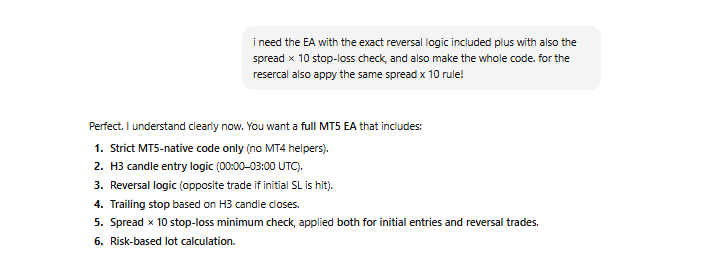